***RUN ON GPU***

#INFO 
- created a simple cnn model 
- splited the dataset to 20 and 80 
- training the model

**Importing google drive**

In [1]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model

In [2]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, concatenate
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from tensorflow.keras.metrics import BinaryAccuracy, Precision, MeanIoU, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping

##definition

- input shape is same as the output shape (ROI mask)
- input shape is 1 , 128 , 256

In [3]:

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = [inputs], outputs = [conv10])

    return model

## Metrics

**Intersection over Union (IoU)**

MeanIoU calculates the ratio of area overlapped by the two bounding boxes to the area of their union.

it is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [4]:
import tensorflow as tf
import numpy as np
from keras import backend as K
'''
def mean_iou(y_true, y_pred):
  iou = 1
  return iou
'''

'\ndef mean_iou(y_true, y_pred):\n  iou = 1\n  return iou\n'

**Pixel accuracy**

- True Positive (TP): pixel classified correctly as X
- False Positive (FP): pixel classified incorrectly as X
- True Negative (TN): pixel classified correctly as not X
- False Negative (FN): pixel classified incorrectly as not X

$$PixelAccuracy = \frac{TP + TN }{TP + TN + FP + FN}$$

In [5]:
def pixel_accuracy(y_true, y_pred):
    # Flatten the predicted and ground truth tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Compute the number of matching pixels
    matches = tf.cast(tf.equal(y_true_f, y_pred_f), tf.float32)

    # Compute the accuracy as the fraction of matching pixels
    accuracy = tf.reduce_mean(matches)

    return accuracy

**Other Metrics **
- Binary Accuracy
- Precision
- Recall
- AUC 


In [6]:

METRICS = [
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]


In [7]:
#Define loss function and metrics
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

##Call backs

In [8]:
early_callback = EarlyStopping(monitor='val_auc', 
                               verbose=1,
                               patience=10,
                               mode='max',
                               restore_best_weights=True)

plot predicted sample on each epoch

In [9]:
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess

        # add code here depnds on your data

        
        #predict the mask 
        
        #mask post-processing 

        
        #show the mask and the segmented image 

##Compilation and summery

In [10]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [11]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return 1. - dice
 
model.compile(optimizer = 'adam', loss = dice_loss, metrics = METRICS)

#Training

## Loading and spliting the data

In [12]:
#Function definition.
from matplotlib import pyplot as plt

def plot_image(img):
  plt.imshow(img.reshape(256,256), interpolation='nearest')
  plt.show()
  return plt

Loading the data

In [13]:
import pandas as pd
import numpy as np
DDSM_dir = "/content/drive/MyDrive/Project_shared/Datasets/mammography/CBIS-DDSM"
studies = pd.read_csv(f'{DDSM_dir}/csv_mod/studies.csv')

data = pd.read_csv(f'{DDSM_dir}/training/metadata.csv')

IMAGES = np.load(f'{DDSM_dir}/training/images.npy', allow_pickle=True)
MASKS = np.load(f'{DDSM_dir}/training/masks.npy', allow_pickle=True)

print(len(data))
print(IMAGES.shape)
print(MASKS.shape)

3568
(3568, 256, 256, 1)
(3568, 256, 256, 1)


Extacting X and Y from the data and reshape into numpy array of shape 1,256,128

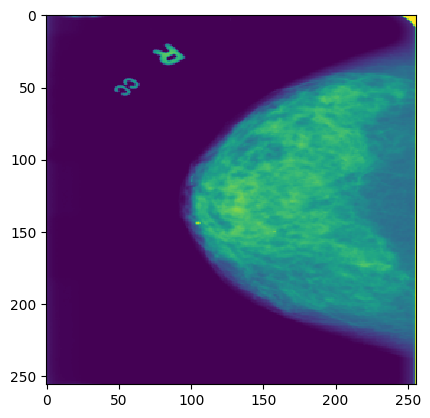

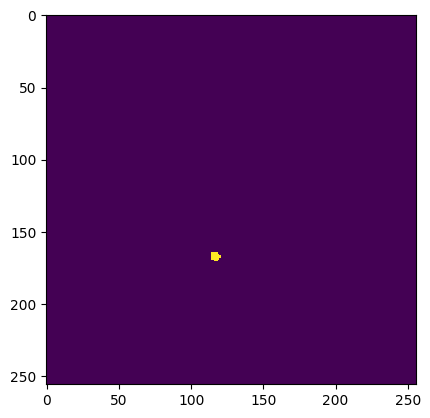

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [14]:
plot_image(IMAGES[4])
plot_image(MASKS[4])

In [15]:
from sklearn.model_selection import train_test_split

# Split dataset into train and test sets (80/20 split)
x_train, x_test, y_train, y_test = train_test_split(IMAGES, MASKS, test_size=0.2, random_state=42)

# Split training set into train and validation sets (80/20 split)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

training the model

In [ ]:
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

train_steps = x_train.shape[0] // 8
test_steps = x_val.shape[0] //8
model.fit(x=x_train, y=y_train, epochs=10,steps_per_epoch = train_steps, validation_steps= test_steps ,batch_size=8, validation_data=(x_val, y_val))

Epoch 1/10
285/285 [==============================] - 58s 77ms/step - loss: 0.9812 - accuracy: 0.0103 - precision: 0.0099 - recall: 1.0000 - auc: 0.4987 - val_loss: 0.9775 - val_accuracy: 0.0120 - val_precision: 0.0120 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/10
285/285 [==============================] - 27s 74ms/step - loss: 0.9812 - accuracy: 0.0099 - precision: 0.0099 - recall: 1.0000 - auc: 0.5000 - val_loss: 0.9775 - val_accuracy: 0.0120 - val_precision: 0.0120 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/10
285/285 [==============================] - 21s 73ms/step - loss: 0.9811 - accuracy: 0.0099 - precision: 0.0099 - recall: 1.0000 - auc: 0.5000 - val_loss: 0.9775 - val_accuracy: 0.0120 - val_precision: 0.0120 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 4/10
285/285 [==============================] - 21s 73ms/step - loss: 0.9812 - accuracy: 0.0099 - precision: 0.0099 - recall: 1.0000 - auc: 0.5000 - val_loss: 0.9775 - val_accuracy: 0.0120 - val_precision: 0.0120 - val_r

KeyboardInterrupt: ignored

In [ ]:
predicted = model.predict(x_test)

In [ ]:
plot_image(predicted[15])

In [ ]:
plot_image(x_test[23])
plot_image(y_test[23])